### Deriving camera calibration from Charucoboard

Normally uses a chessboard.  However, if we have Charucos, 
then we should use that.  Follows the tutorial [here](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html).  

In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

import cv2, numpy, time
vfile = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/charucoVI000181.mp4"

cap = cv2.VideoCapture(vfile)
nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
imageSize = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

print("nframes", nframes, "imageSize", imageSize)
#videos.frameselectinteractive(cap, None, None)

nframes 771 imageSize (1920, 1080)


Quality of some frames is much worse


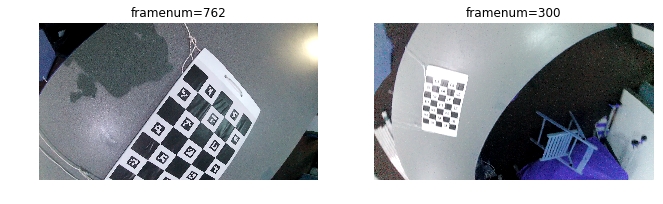

In [22]:
print("Quality of some frames is much worse")
framenum0, framenum1 = 64, 300
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
cap.set(cv2.CAP_PROP_POS_FRAMES, framenum0)
flag, frame = cap.retrieve()
plt.imshow(frame)
plt.title("framenum=%d"%framenum)
plt.axis("off")
plt.subplot(1,2,2)
cap.set(cv2.CAP_PROP_POS_FRAMES, framenum1)
flag, frame = cap.retrieve()
plt.imshow(frame)
plt.title("framenum=%d"%framenum1)
plt.axis("off")
plt.show()


In [23]:
print("Scan through all frames detecting charuco boards")
iCClist = [ ]
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
parameters =  cv2.aruco.DetectorParameters_create()
squaresX, squaresY, markersquareratio = 5, 7, 0.5
chesssquareLength = 276.0/7
charboard = cv2.aruco.CharucoBoard_create(squaresX, squaresY, chesssquareLength, chesssquareLength*markersquareratio, aruco_dict)
winSize, zeroZone, criteria = (5, 5), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)

for i in range(nframes):
    flag, frame = cap.read()
    framenum = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    markerCorners, markerIds, rejectedMarkers = cv2.aruco.detectMarkers(frame, aruco_dict)
    if markerCorners:
        frameg = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        for corner in markerCorners:  # optional loop
            cv2.cornerSubPix(frameg, corner, winSize, zeroZone, criteria)
        res2 = cv2.aruco.interpolateCornersCharuco(markerCorners, markerIds, frameg, charboard)
        iCClist.append((framenum, res2))
    if (i%100) == 0:
        print(framenum, "/", nframes)

Scan through all frames detecting charuco boards
1 / 771
101 / 771
201 / 771
301 / 771
401 / 771
501 / 771
601 / 771
701 / 771


markers found in frame out of 24


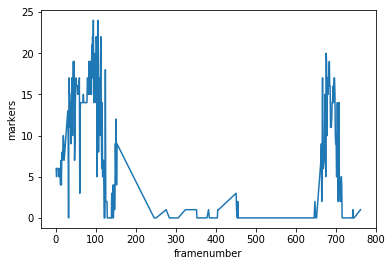

In [28]:
plt.plot([x[0] for x in iCClist], [x[1][0]  for x in iCClist])
print("markers found in frame out of", (squaresX-1)*(squaresY-1))
plt.xlabel("framenumber")
plt.ylabel("markers");


In [68]:
print("Subselecting sets of corners to use for calibration")
allCorners, allIds = [ ], [ ]
for framenum, res2 in iCClist[::2]:
    if res2[1] is not None and res2[2] is not None and len(res2[1])>=8:
        allCorners.append(res2[1])
        allIds.append(res2[2])
        
print("Number of charuco frame images to use:", len(allCorners))

Subselecting sets of corners to use for calibration
Number of charuco frame images to use: 64


In [69]:
t0 = time.time()
cameraMatrixInit = numpy.array([[ 1000.,    0., imageSize[0]/2.],
                                [    0., 1000., imageSize[1]/2.],
                                [    0.,    0.,           1.]])

distCoeffsInit = numpy.zeros((5,1))
flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
#flags = (cv2.CALIB_RATIONAL_MODEL)
(ret, cameraMatrix, distCoeffs,
    rotation_vectors, translation_vectors,
    stdDeviationsIntrinsics, stdDeviationsExtrinsics,
    perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=charboard,
                      imageSize=imageSize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

t1 = time.time()
print("Time taken to calculate", int(t1-t0), "seconds\n")
print("cameraMatrix = numpy.\\\n%s" % repr(camera_matrix))
print("distCoeffs = numpy.%s" % repr(distCoeffs.T[:,:5]))


Time taken to calculate 74 seconds

cameraMatrix = numpy.\
array([[1.15361760e+03, 0.00000000e+00, 9.15545481e+02],
       [0.00000000e+00, 1.15361760e+03, 4.97119647e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-3.29517038,  3.408778  ,  0.01401372,  0.01008172,  1.83357818]])


Preview the undistort.


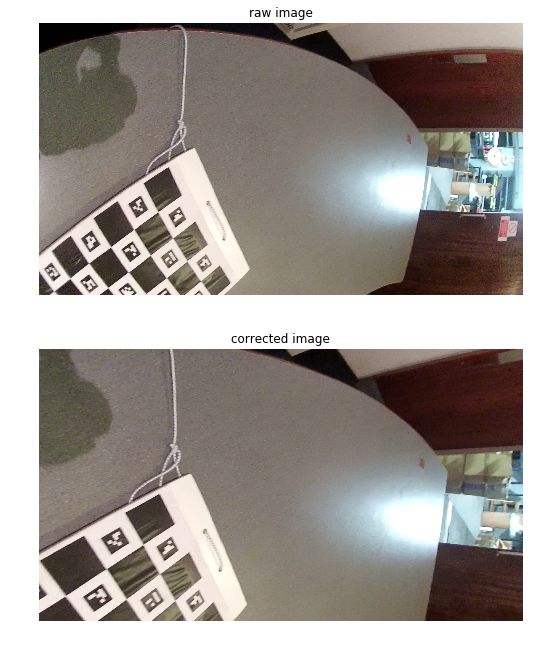

<Figure size 432x288 with 0 Axes>

In [70]:
print("Preview the undistort.")
framenum = 13
cap.set(cv2.CAP_PROP_POS_FRAMES, framenum)
flag, frame = cap.retrieve()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(13,11))
plt.subplot(2,1,1)
frame_undistort = cv2.undistort(frame, cameraMatrix, distCoeffs, None)
plt.imshow(frame)
plt.title("raw image")
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(frame_undistort)
plt.title("corrected image")
plt.axis("off")
plt.show()
plt.subplots_adjust(0,0,1,1,0.05,0.05)


In [ ]:
cameraMatrix = numpy.\
array([[1.15361760e+03, 0.00000000e+00, 9.15545481e+02],
       [0.00000000e+00, 1.15361760e+03, 4.97119647e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-3.29517038,  3.408778  ,  0.01401372,  0.01008172,  1.83357818]])
